In [237]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from T01_prototype.S00_utils import loadPickle, plot_res, store_results
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [239]:
from T02_fusion_transformer.S02_attn.models import MyModel_Attn as MyModel

In [240]:
df = pd.read_excel("../T01_prototype/output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [241]:
colsY = ["y1", "y2", "y3"]
# colsX = [c for c in df.columns if c not in colsY]
colsX = ["m1", "m2", "m3"]

dfX = df[colsX]
dfY = df[colsY]

In [242]:
dfData = loadPickle("../T01_prototype/output/S11__2025-04-21-052441.pickle")

In [243]:
dfData
tsArr = [t[1] for t in dfData["ts"].values]

In [244]:
# Max length
maxTime = 0
for ts in tsArr:
    maxTime = len(ts) if maxTime < len(ts) else maxTime

print(maxTime)

298


(100, 20, 2)


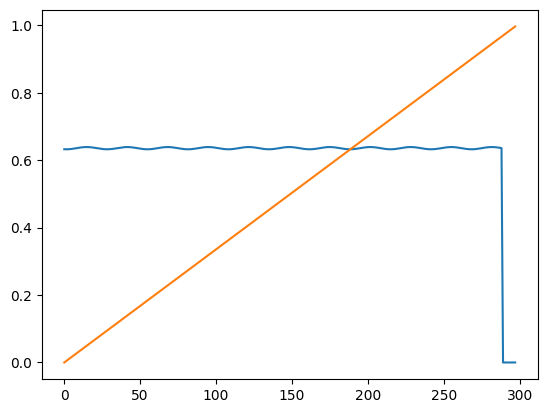

In [245]:
# Scaling and Padding
# TODO: Needs to only calculate mean, std, min, max from training example.

SCALING_TYPE = "Min_Max"
# SCALING_TYPE = "STANDARDIZATION"

tsArrConcat = np.concatenate(tsArr)
if SCALING_TYPE == "STANDARDIZATION":
    meanVal = np.mean(tsArrConcat)
    stdVal = np.std(tsArrConcat)
elif SCALING_TYPE == "Min_Max":
    maxVal = np.max(tsArrConcat)
    minVal = np.min(tsArrConcat)

# Shape = (Batch, Time, Features)
TsData_std = np.zeros((dfData.shape[0], maxTime, 2))
for idx, ts in enumerate(tsArr):
    if SCALING_TYPE == "STANDARDIZATION":
        ts_std = (ts - meanVal) / stdVal
    elif SCALING_TYPE == "Min_Max":
        ts_std = (ts - minVal) / (maxVal - minVal)

    TsData_std[idx, : len(ts), 0] = ts_std  # Scaling
    TsData_std[idx, len(ts) :, 0] = 0  # Padding

    # Add time index (scaled)
    TsData_std[idx, :, 1] = np.arange(maxTime) / maxTime  # Time index
plt.plot(TsData_std[0, :, 0])
plt.plot(TsData_std[0, :, 1])

# TRUNCATION
TsData_std = TsData_std[:, :20, :]

print(TsData_std.shape)

In [246]:
# Find the ending time for each time series
et_arr = [float(t[0][-1]) for t in dfData["ts"].values]
num_output = dfY.shape[1]
tsEndTimes = np.zeros((dfData.shape[0], dfY.shape[1], 1))
for idx, et in enumerate(et_arr):
    for t in range(num_output):
        tsEndTimes[idx, t, 0] = (et + t) / maxTime

In [247]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0, test_size=0.30)
idxs = np.arange(df.shape[0])
idxTrain, idxTest = next(cv.split(X=idxs))
print(idxTrain)
print(idxTest)

[60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40 38  5 91 59  0 34
 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29 49 97 98 69 20 94
 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96 67 64 47 44]
[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76]


In [248]:
dfX_train = dfX.iloc[idxTrain, :]
dfX_test = dfX.iloc[idxTest, :]
dfY_train = dfY.iloc[idxTrain, :]
dfY_test = dfY.iloc[idxTest, :]
Ts_train_std = TsData_std[idxTrain, :]
Ts_test_std = TsData_std[idxTest, :]
Fu_train_std = tsEndTimes[idxTrain, :]
Fu_test_std = tsEndTimes[idxTest, :]

In [249]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(dfX_train)
X_test_std = scX.transform(dfX_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(dfY_train)
Y_test_std = scY.transform(dfY_test)

In [250]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)
Ts_train_std = torch.tensor(Ts_train_std, dtype=torch.float32)
Ts_test_std = torch.tensor(Ts_test_std, dtype=torch.float32)
Fu_train_std = torch.tensor(Fu_train_std, dtype=torch.float32)
Fu_test_std = torch.tensor(Fu_test_std, dtype=torch.float32)

In [251]:
tab_num_features = dfX.shape[1]
ts_embedding_size = 8
ts_num_features = Ts_train_std.shape[-1]
lstm_num_layers = 2
lstm_dropout = 0.5
attn_n_head = 1
num_output = Y_test_std.shape[1]

# Initialize model
model = MyModel(
    tab_num_features=tab_num_features,
    ts_embedding_size=ts_embedding_size,
    ts_num_features=ts_num_features,
    lstm_num_layers=lstm_num_layers,
    lstm_dropout=lstm_dropout,
    attn_n_head=attn_n_head,
    num_output=num_output,
)

In [252]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.01)

0 0.0838535875082016
1 0.055428169667720795
2 0.05198881775140762
3 0.054652053862810135
4 0.0493527315557003
5 0.05266508087515831
6 0.05173015594482422
7 0.05280525982379913
8 0.04783361405134201
9 0.05348920822143555
10 0.04988235980272293
11 0.05208154767751694
12 0.05437863618135452
13 0.051541782915592194
14 0.05210188776254654
15 0.051262591034173965
16 0.05348943546414375
17 0.05314469337463379
18 0.051846642047166824
19 0.05189712345600128
20 0.05270892754197121
21 0.0528252013027668
22 0.054062116891145706
23 0.0533626489341259
24 0.053359560668468475
25 0.052731648087501526
26 0.05374372377991676
27 0.05377219617366791
28 0.05357345938682556
29 0.0532463863492012
30 0.05299236625432968
31 0.05208512768149376
32 0.05228302255272865
33 0.05249200016260147
34 0.052695222198963165
35 0.05278892442584038
36 0.05375051498413086
37 0.05350590869784355
38 0.053147200495004654
39 0.052459124475717545
40 0.05178608372807503
41 0.05219154432415962
42 0.05255473032593727
43 0.0525445677

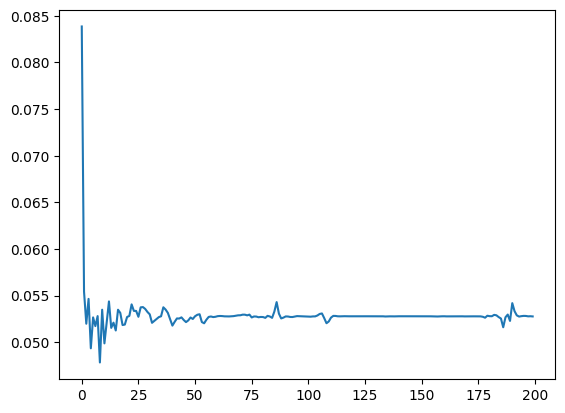

In [253]:
n_epochs = 200
# number of epochs to run
batch_size = 5  # size of each batch
batch_start = torch.arange(0, len(X_train_std), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            x_tab_batch = X_train_std[start : start + batch_size]
            x_ts_batch = Ts_train_std[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            x_future = Fu_train_std[start : start + batch_size]
            # forward pass
            y_pred, _ = model(
                x_tab=x_tab_batch,
                x_ts=x_ts_batch,
                x_future=x_future,
            )
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred, _ = model(x_ts=Ts_test_std, x_tab=X_test_std, x_future=Fu_test_std)
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

    print(epoch, mse)
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [254]:
model.eval()
Y_train_pred, attn_train = model(
    x_ts=Ts_train_std,
    x_tab=X_train_std,
    x_future=Fu_train_std,
)
Y_test_pred, attn_test = model(
    x_ts=Ts_test_std,
    x_tab=X_test_std,
    x_future=Fu_test_std,
)

In [255]:
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

In [256]:
if not isinstance(Y_train_std, np.ndarray):
    Y_train_std = Y_train_std.detach().numpy()
    Y_test_std = Y_test_std.detach().numpy()


,MSE Train,MSE Test,R2 Train,R2 Test
0,0.050676,0.054257,-0.130799,-0.012366
1,0.038517,0.033830,-0.002918,-0.094264
2,0.063284,0.055413,-0.076327,-0.057276


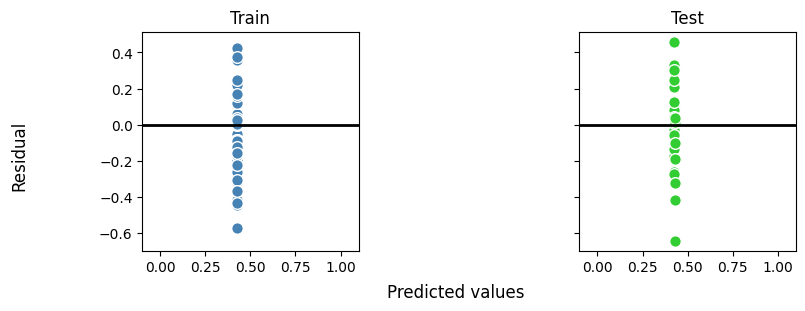

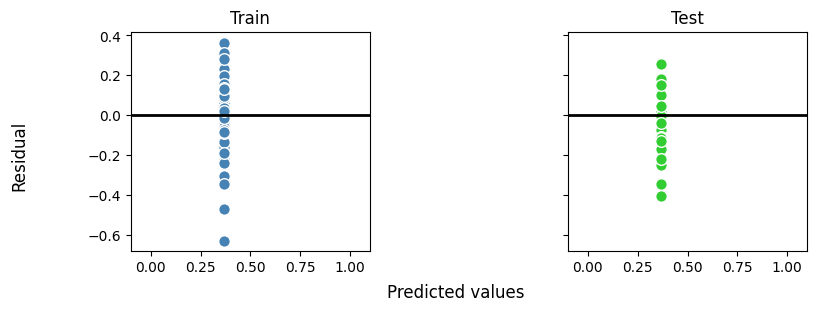

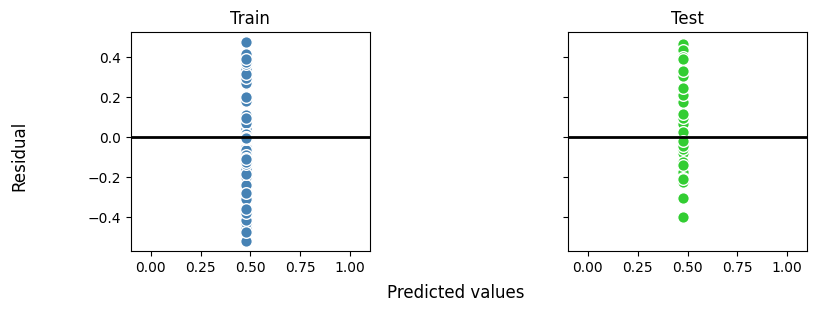

In [257]:
resArr = []
for i in range(dfY.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes

In [258]:
att = attn_train.detach().numpy()
print(att.shape)

(70, 23, 1, 23)


In [259]:
att = attn_train.detach().numpy()
dataArr = []
for sample in range(0, att.shape[0]):
    for head in range(0, att.shape[2]):
        data = att[sample, :, head, :]
        dataArr.append(data[-1, :])  # Can choose -2 or -3 for specific output

df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.043179,0.042903,0.043051,0.043158,0.043204,0.043216,0.043215,0.043210,0.043205,0.043200,...,0.043191,0.043190,0.043189,0.043188,0.043188,0.043188,0.043188,0.048568,0.045327,0.042658
1,0.043477,0.043296,0.043439,0.043525,0.043557,0.043562,0.043558,0.043554,0.043550,0.043547,...,0.043542,0.043541,0.043540,0.043538,0.043536,0.043535,0.043534,0.047085,0.042803,0.039646
2,0.043513,0.043386,0.043537,0.043620,0.043648,0.043652,0.043647,0.043643,0.043640,0.043638,...,0.043635,0.043634,0.043632,0.043630,0.043628,0.043625,0.043623,0.046699,0.042165,0.038896
3,0.043485,0.043389,0.043548,0.043633,0.043661,0.043664,0.043661,0.043656,0.043653,0.043652,...,0.043649,0.043648,0.043646,0.043644,0.043642,0.043639,0.043637,0.046657,0.042086,0.038798
4,0.043453,0.043373,0.043539,0.043626,0.043655,0.043659,0.043655,0.043651,0.043648,0.043647,...,0.043645,0.043643,0.043641,0.043639,0.043637,0.043634,0.043632,0.046695,0.042138,0.038853


Text(0, 0.5, 'Attention Score')

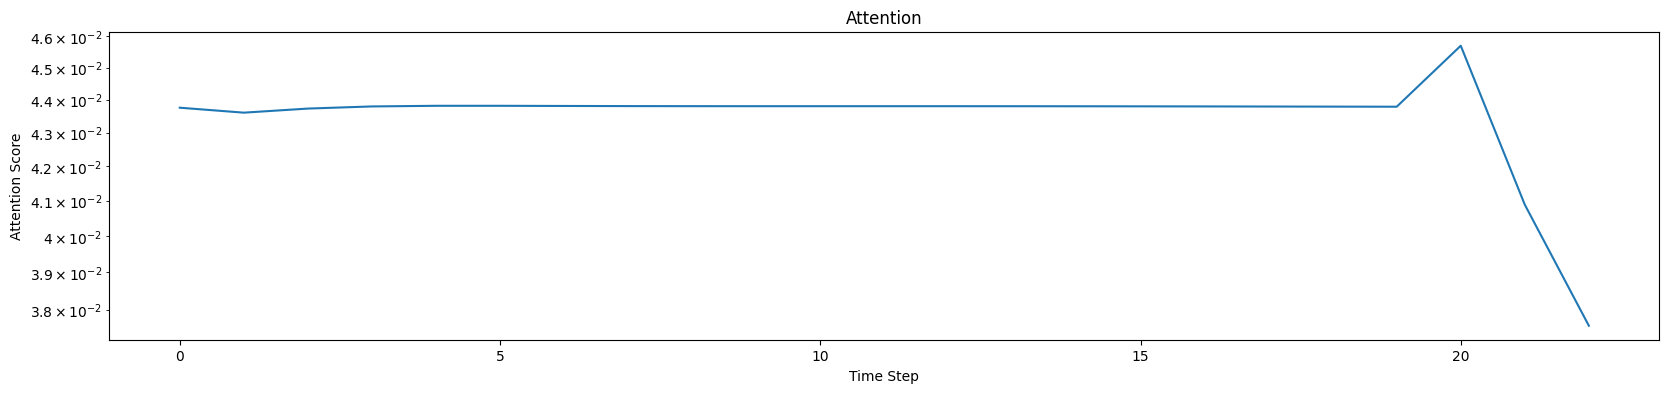

In [260]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 4))
df.mean(axis=0).plot(logy=True, ax=ax)
ax.set_title("Attention")
ax.set_xlabel("Time Step")
ax.set_ylabel("Attention Score")